<a href="https://colab.research.google.com/github/SEOYUNJE/Endoscope-Object-Detection/blob/main/Calibrated-Confidence-Score/colonoscopy_pytorchlightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opendatasets
import opendatasets as od

od.download('https://www.kaggle.com/datasets/seoyunje/colonoscopy-256x256-resized-png')
od.download('https://www.kaggle.com/datasets/msyu78/metadataset')

Skipping, found downloaded files in "./colonoscopy-256x256-resized-png" (use force=True to force download)
Skipping, found downloaded files in "./metadataset" (use force=True to force download)


## 1. Import Library
___

In [2]:
!pip install -q colorama
!pip install -q pytorch_lightning

In [3]:
import os
import random
from tqdm import tqdm

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from colorama import Fore

from glob import glob
import cv2
from PIL import Image

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

import torch
import timm
import torch.nn as nn
from torch import optim
from torch.cuda import amp
import torch.functional as F
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#### Configuration

In [4]:
class CFG:
    output_dir = 'runs/classify'
    seed = 2025
    img_size = [256,256]
    num_classes = 3
    backbone_name = 'efficientnet_b0'

    fold = 0
    num_epochs = 10
    num_workers = 2

    batch_size = 16

    base_lr = 1e-3
    min_lr = 1e-9
    weight_decay = 1e-5

    amp = True
    n_accumulate = 1
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_count = torch.cuda.device_count()

os.makedirs(CFG.output_dir, exist_ok=True)
print('Device is', CFG.device)
print('Num GPU of machine is ', CFG.device_count)

Device is cuda
Num GPU of machine is  1


#### Reproducibility

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

## 2. Road and Read Data
___

In [6]:
df = pd.read_csv('/content/metadataset/colonoscopy_data2.csv')

train_meta = pd.read_csv('/content/colonoscopy-256x256-resized-png/train_meta.csv')
train_id = train_meta['image_id'].unique()

train_df = df[df['image_id'].isin(train_id)]

test_meta = pd.read_csv('/content/colonoscopy-256x256-resized-png/test_meta.csv')
test_id = test_meta['image_id'].unique()

test_df = df[df['image_id'].isin(test_id)]

In [7]:
## label 0: ulcer
## label 1: polyp
## label 2: cancer

train_df = train_df.groupby(['image_id']).agg('first').reset_index()
train_df = train_df[['image_id','height','width','organ','lesion_label','lesion']]

test_df = test_df.groupby(['image_id']).agg('first').reset_index()
test_df = test_df[['image_id','height','width','organ','lesion_label','lesion']]

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (_, val_idx) in enumerate(skf.split(train_df, train_df['lesion'])):
    train_df.loc[val_idx, 'fold'] = i

**Image File Path**

In [9]:
train_df['width'] = CFG.img_size[0]
train_df['height'] = CFG.img_size[1]

mapping_path = {os.path.basename(x): x for x in glob('/content/colonoscopy-256x256-resized-png/train/*')}
train_df['path'] = train_df['image_id'].map(mapping_path)

test_df['width'] = CFG.img_size[0]
test_df['height'] = CFG.img_size[1]

mapping_path = {os.path.basename(x): x for x in glob('/content/colonoscopy-256x256-resized-png/test/*')}
test_df['path'] = test_df['image_id'].map(mapping_path)

**One Hot Encoding**

In [10]:
for col in train_df['lesion'].unique():
    train_df[col] = np.where(train_df['lesion'].str.contains(col), 1.0, 0.0).astype('float32')
    test_df[col] = np.where(test_df['lesion'].str.contains(col), 1.0, 0.0).astype('float32')

TARGET = train_df['lesion'].unique()
print(TARGET)

['ulcer' 'polyp' 'cancer']


## 3. Build Dataset
___

In [11]:
def get_train_transform():
    return A.Compose(
        [
         A.HorizontalFlip(p=0.5),
         A.Resize(*CFG.img_size, p=1.0)
        ]
    )

def get_valid_transform():
    return A.Compose(
        [
            A.Resize(*CFG.img_size, p=1.0)
        ]
    )

In [12]:
class ColonoDataset(Dataset):
    def __init__(self, data, transforms=None):
        super(ColonoDataset, self).__init__()
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        path = row['path']
        img = Image.open(path)
        img = np.array(img).astype(np.float32)

        m = np.nanmean(img)
        img = np.nan_to_num(img, nan=m)

        if self.transforms:
            sample = self.transforms(image=img)
            img = sample['image']

        ## Preprocessing
        img /= 255
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = (img-mean) / std

        X = torch.tensor(img.transpose(2,0,1).astype(np.float32))
        y = torch.tensor(row[TARGET].values.astype(np.float32))

        return X, y

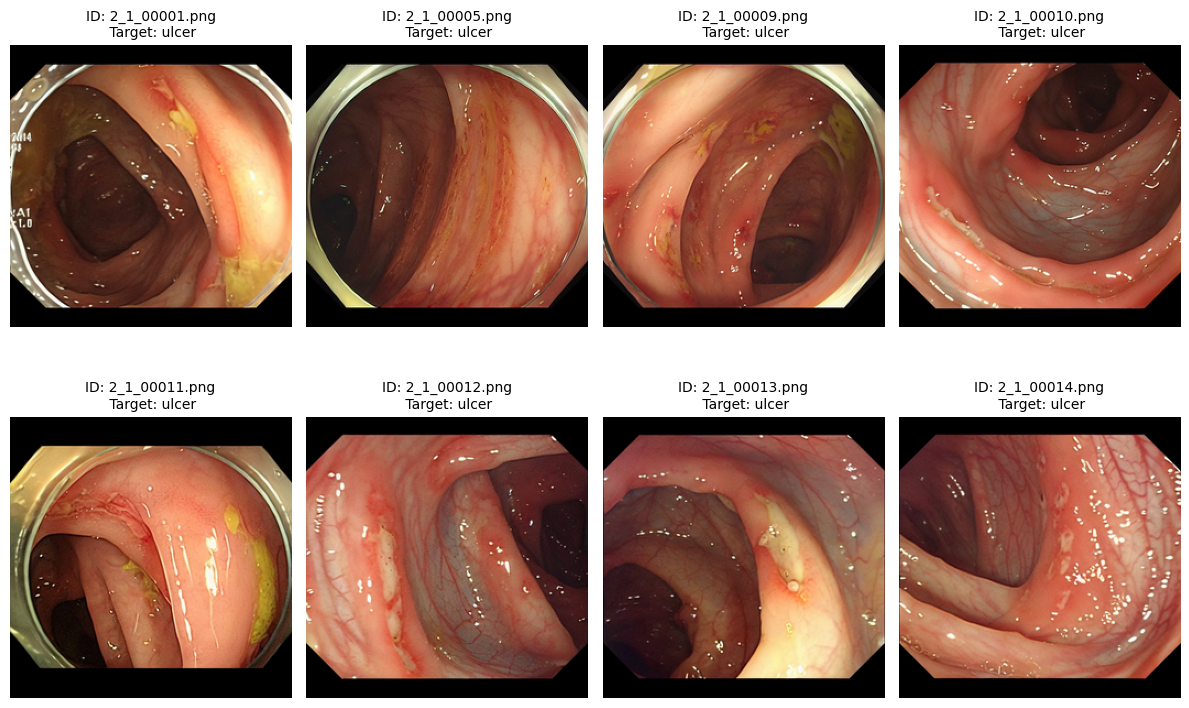

In [13]:
gen = ColonoDataset(train_df, transforms=get_train_transform())

repeat = 0

plt.figure(figsize=(12,8))

for i, (x,y) in enumerate(gen):
    plt.subplot(2, 4, i+1)
    image_id = train_df.iloc[i]['image_id']
    target = train_df.iloc[i]['lesion']
    plt.title(f'ID: {image_id}\n Target: {target}', size=10)
    img = x.cpu().permute(1,2,0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = (img*255).astype(np.uint8)

    plt.imshow(img)
    plt.axis('off')

    repeat += 1
    if repeat == 8: break

plt.tight_layout()
plt.show()


## 4. Build Trainer
___

In [14]:
class ColonoEffNet(pl.LightningModule):

    def __init__(self):
        super(ColonoEffNet, self).__init__()
        self.feature_extractor = timm.create_model(CFG.backbone_name, pretrained=True, num_classes=0, global_pool='avg')
        self.classifier = nn.Linear(self.feature_extractor.num_features, CFG.num_classes)
        self.criterion = nn.BCELoss()
        self.history = defaultdict(list)
        self.true = []
        self.pred = []


    def forward(self,x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return torch.sigmoid(x)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, targets)
        self.history['train_loss'].append(loss.item())
        self.log('train_loss', loss, prog_bar=True)

        lr = self.optimizers().param_groups[0]['lr']
        self.history['lr'].append(lr)
        self.log('lr', lr, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, targets)

        self.log(f'valid_loss', loss, prog_bar=True)
        self.history[f'valid_loss'].append(loss.item())

    def test_step(self, batch, batch_idx):
        images, targets = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, targets)

        self.pred.append(outputs.cpu().numpy())
        self.true.append(targets.cpu().numpy())

        self.log(f'test_loss', loss, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),lr=CFG.base_lr, weight_decay=CFG.weight_decay)

        scheduler_dict = {
            'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_epochs*len(train_loader), eta_min=CFG.min_lr,
            last_epoch=-1, verbose=False
            ),
            'interval': 'step'
        }

        return {'optimizer': optimizer, 'lr_scheduler': scheduler_dict}

## 5. Training
___

In [15]:
train_ds = ColonoDataset(train_df[train_df['fold'] != CFG.fold])
train_loader = DataLoader(train_ds, shuffle=True, batch_size=CFG.batch_size,
                          drop_last=False, num_workers = CFG.num_workers)

valid_ds = ColonoDataset(train_df[train_df['fold'] == CFG.fold])
valid_loader = DataLoader(valid_ds, shuffle=False, batch_size=CFG.batch_size*2,
                          drop_last=False, num_workers = CFG.num_workers)

trainer = pl.Trainer(
    max_epochs=CFG.num_epochs,
    accelerator='auto',
    devices=1,
    callbacks = [LearningRateMonitor(logging_interval='step')]
    )

model = ColonoEffNet()

model.to(CFG.device); model.train()

trainer.fit(model = model, train_dataloaders = train_loader,
            val_dataloaders = valid_loader)
trainer.save_checkpoint(f'{CFG.output_dir}/best_effnet.ckpt')


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type         | Params | Mode 
-----------------------------------------------------------
0 | feature_extractor | EfficientNet | 4.0 M  | train
1 | classifier        | Linear       | 3.8 K  | train
2 | criterion         | BCELoss      | 0      | train
-----------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.046    Total estimated model params size (MB)
339       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


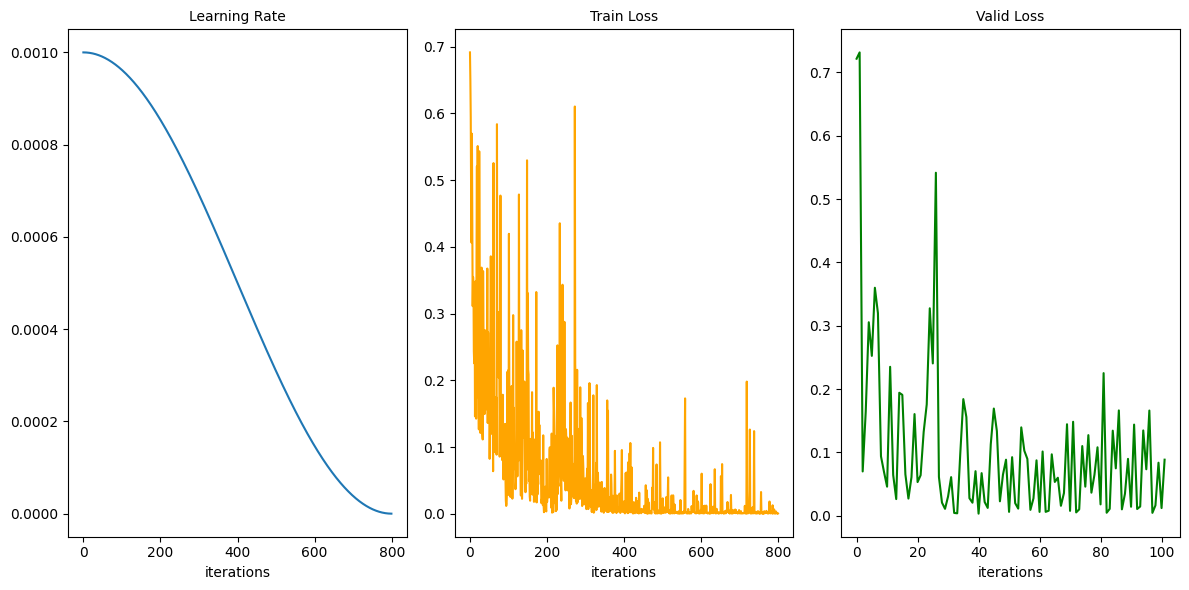

In [16]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.title('Learning Rate', size=10)
plt.plot(model.history['lr'])
plt.xlabel('iterations')

plt.subplot(1,3,2)
plt.title('Train Loss', size=10)
plt.plot(model.history['train_loss'], color='orange')
plt.xlabel('iterations')

plt.subplot(1,3,3)
plt.title('Valid Loss', size=10)
plt.plot(model.history['valid_loss'], color='green')
plt.xlabel('iterations')


plt.tight_layout()
plt.show()

**Metric**

In [20]:
trainer.test(dataloaders=valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=9-step=800.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=9-step=800.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.060448579490184784    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.060448579490184784}]

In [21]:
pred = np.concatenate(model.pred)
true = np.concatenate(model.true)

threshold = 0.5
pred_thr = (pred >= threshold).astype(int)

for i in range(len(TARGET)):
    precision = precision_score(true[:,i], pred_thr[:,i], average='binary')
    recall = recall_score(true[:,i], pred_thr[:,i], average='binary')
    accuracy = accuracy_score(true[:,i], pred_thr[:,i])

    print(f'{Fore.BLUE}#'*25)
    print(f'Class: {TARGET[i]}')
    print(f'#'*25)
    print(f'{Fore.BLACK}Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Accuracy: {accuracy}')
    print('\n')

#########################
Class: ulcer
#########################
Precision: 0.975609756097561
Recall: 1.0
Accuracy: 0.99375


#########################
Class: polyp
#########################
Precision: 0.96
Recall: 0.9
Accuracy: 0.965625


#########################
Class: cancer
#########################
Precision: 0.9573170731707317
Recall: 0.98125
Accuracy: 0.96875




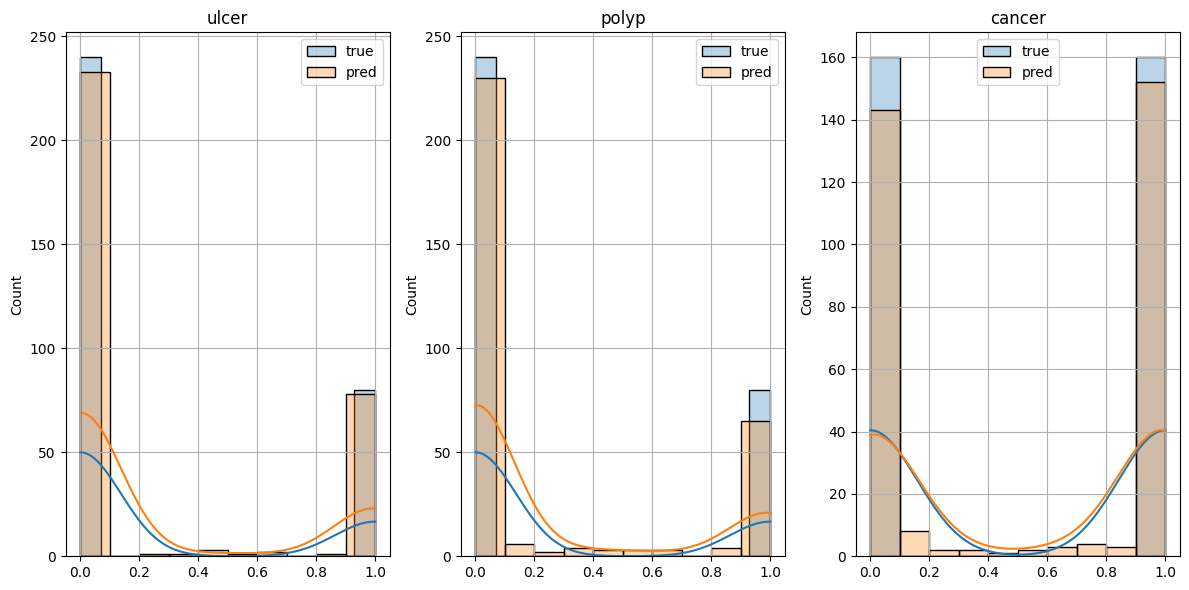

In [22]:
plt.figure(figsize=(12,6))

for i in range(len(TARGET)):
    plt.subplot(1,3,i+1)
    plt.title(TARGET[i])
    sns.histplot(true[:,i], alpha=0.3, kde=True, label='true')
    sns.histplot(pred[:,i], alpha=0.3, kde=True, label='pred')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
del trainer, model, train_loader, valid_loader

## 6. Inference
___

In [24]:
test_ds = ColonoDataset(test_df)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=CFG.batch_size*2,
                          drop_last=False, num_workers = CFG.num_workers)

model = ColonoEffNet.load_from_checkpoint(f'{CFG.output_dir}/best_effnet.ckpt')

model.to(CFG.device); model.eval()

test_pred = []
test_true = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        images, targets = batch
        images = images.to(CFG.device)
        output = model(images).cpu().numpy()
        test_pred.append(output)
        test_true.append(targets.cpu().numpy())

test_pred = np.concatenate(test_pred, axis=0)
test_true = np.concatenate(test_true, axis=0)

100%|██████████| 13/13 [00:02<00:00,  5.10it/s]


In [25]:
threshold = 0.5
test_pred_thr = (test_pred >= threshold).astype(int)

for i in range(len(TARGET)):
    precision = precision_score(test_true[:,i], test_pred_thr[:,i], average='binary')
    recall = recall_score(test_true[:,i], test_pred_thr[:,i], average='binary')
    accuracy = accuracy_score(test_true[:,i], test_pred_thr[:,i])

    print(f'{Fore.BLUE}#'*25)
    print(f'Class: {TARGET[i]}')
    print(f'#'*25)
    print(f'{Fore.BLACK}Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Accuracy: {accuracy}')
    print('\n')

#########################
Class: ulcer
#########################
Precision: 0.970873786407767
Recall: 1.0
Accuracy: 0.9925


#########################
Class: polyp
#########################
Precision: 0.93
Recall: 0.93
Accuracy: 0.965


#########################
Class: cancer
#########################
Precision: 0.9595959595959596
Recall: 0.95
Accuracy: 0.955




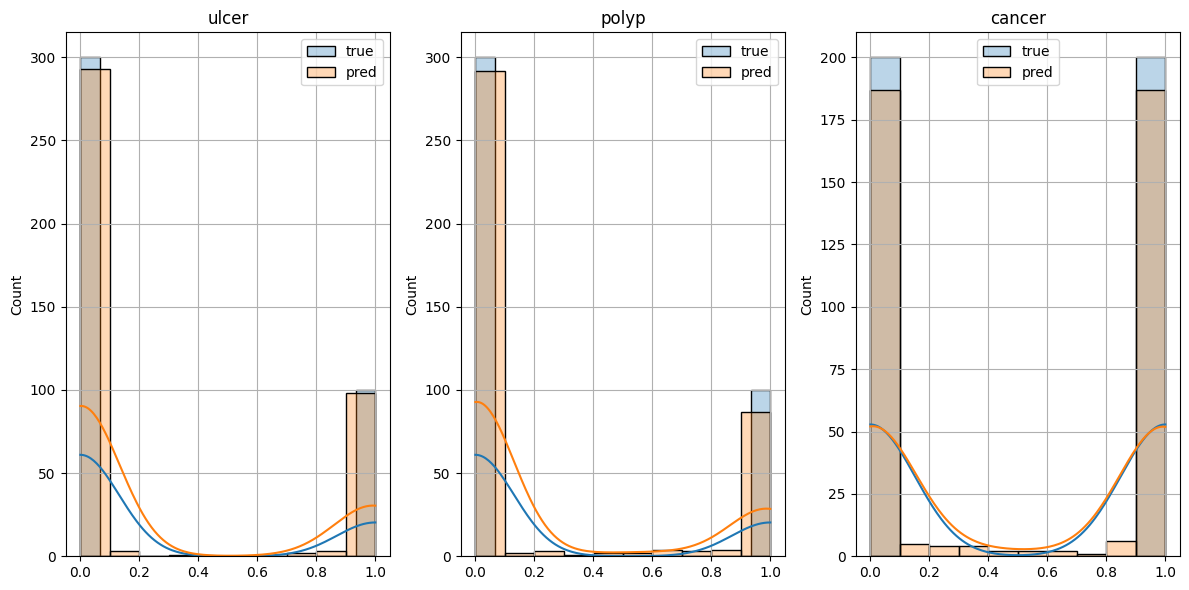

In [26]:
plt.figure(figsize=(12,6))

for i in range(len(TARGET)):
    plt.subplot(1,3,i+1)
    plt.title(TARGET[i])
    sns.histplot(test_true[:,i], alpha=0.3, kde=True, label='true')
    sns.histplot(test_pred[:,i], alpha=0.3, kde=True, label='pred')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()